In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, top_k_accuracy_score
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms
from PIL import Image
from imutils import paths
from torchvision.models import resnet18, ResNet18_Weights
import json
from collections import Counter

seed = 42
np.random.seed(seed)
torch.manual_seed(seed)

# Create outputs folder
dir = "/content/drive/MyDrive/SHBT261/Project/"
save_dir = os.path.join(dir, "outputs/resnet_results")
os.makedirs(save_dir, exist_ok=True)

#### Load data and processing

100%|██████████| 9144/9144 [00:00<00:00, 1217623.84it/s]
/tmp/ipython-input-3217294128.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y=labels,order=pd.Series(labels).value_counts().index, palette="viridis")


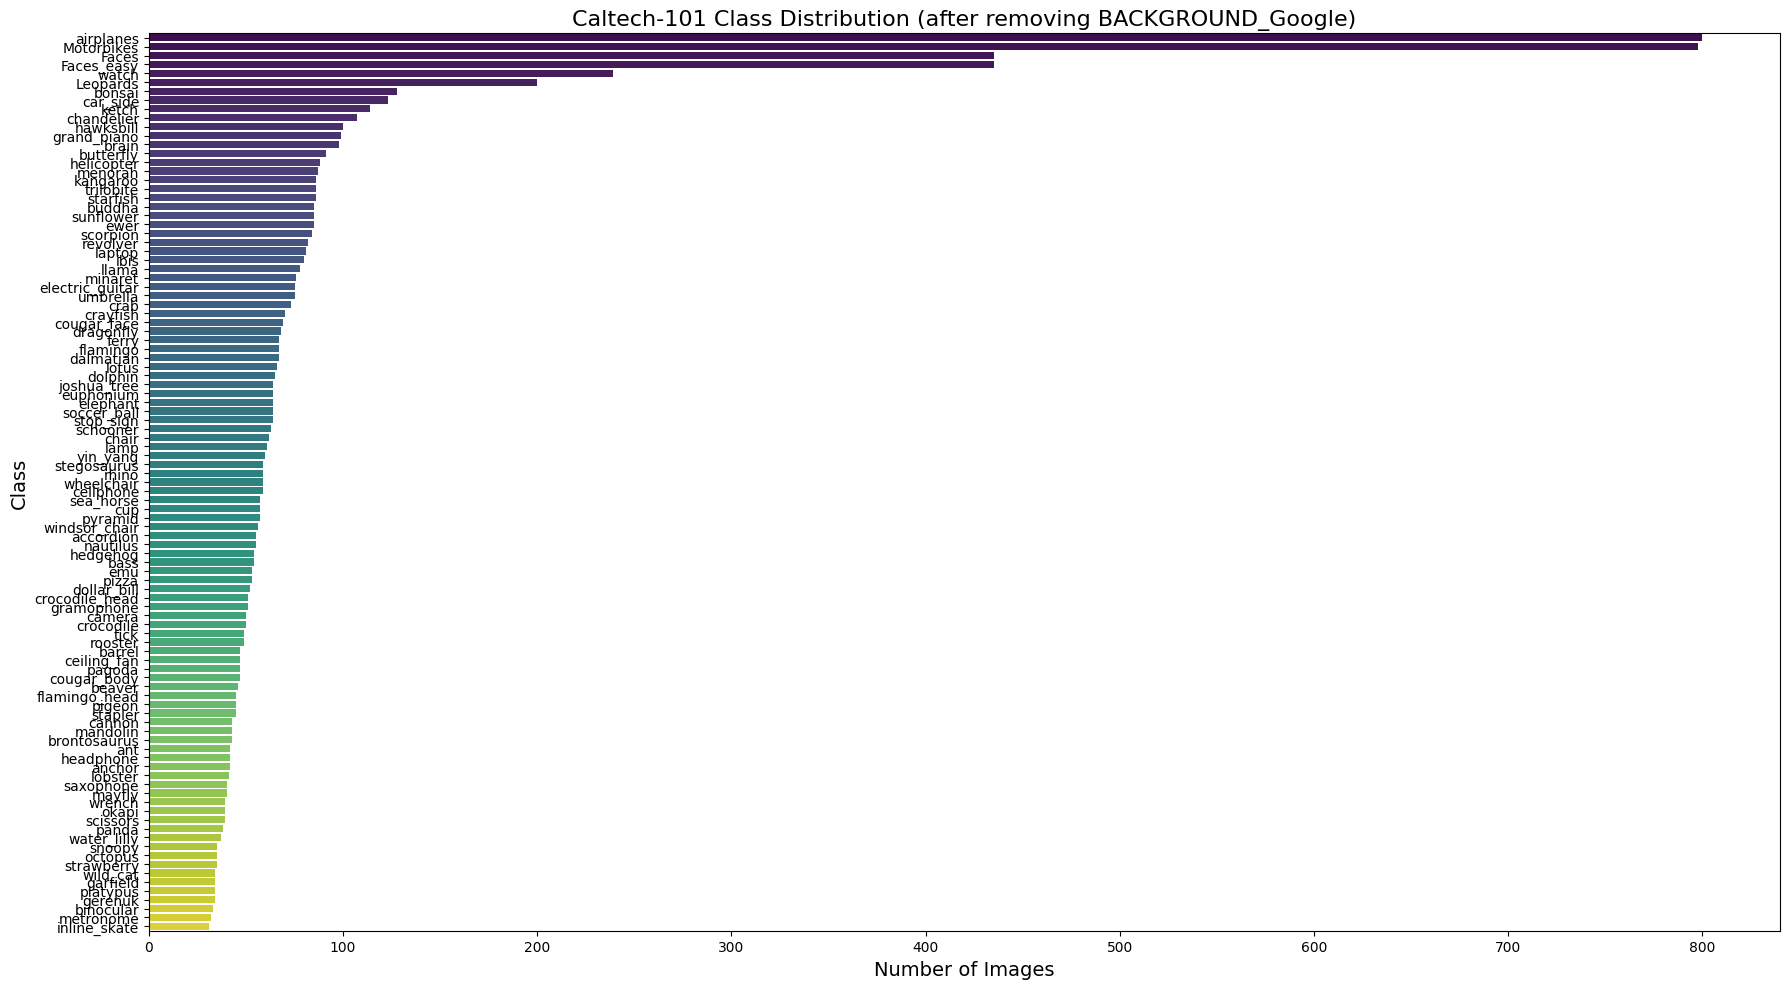

Total Number of Classes: 101


In [3]:
# Load image and preprocess
img_dir = os.path.join(dir, "dataset/caltech-101")
image_paths = list(paths.list_images(img_dir))

data, labels = [], []

for img_path in tqdm(image_paths):
    label = img_path.split(os.path.sep)[-2]
    if label == "BACKGROUND_Google":  # remove this class
        continue
    labels.append(label)
    data.append(img_path)

# Plot class distribution
plt.figure(figsize=(18, 10))
sns.countplot(y=labels,order=pd.Series(labels).value_counts().index, palette="viridis")
plt.title("Caltech-101 Class Distribution (after removing BACKGROUND_Google)", fontsize=16)
plt.xlabel("Number of Images", fontsize=14)
plt.ylabel("Class", fontsize=14)
plt.tight_layout()

# Save figure
plt.savefig(os.path.join(dir, "outputs/class_distribution.png"), dpi=300)
plt.show()

# Encode labels
lb = LabelEncoder()
labels = lb.fit_transform(labels)

print(f"Total Number of Classes: {len(lb.classes_)}")

In [4]:
# Define custom dataset
class CaltechDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        label = self.labels[idx]
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image, label

#### Split dataset and transform

In [5]:
# Hyperparameters and DataLoaders
image_size = 128        # 128 or 64
optimizer_name = "adam"  # "adam" or "sgd"
learning_rate = 1e-4
batch_size = 32
num_epochs = 30
patience = 5
weight_decay=1e-4

# Data augmentation and normalization
train_transform = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.1, contrast=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

val_transform = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# Stratified split 70/15/15
train_paths, temp_paths, train_labels, temp_labels = train_test_split(
    data, labels, test_size=0.30, stratify=labels, random_state=seed
)
val_paths, test_paths, val_labels, test_labels = train_test_split(
    temp_paths, temp_labels, test_size=0.50, stratify=temp_labels, random_state=seed
)

print(f"Train: {len(train_paths)}, Val: {len(val_paths)}, Test: {len(test_paths)}")

train_dataset = CaltechDataset(train_paths, train_labels, train_transform)
val_dataset = CaltechDataset(val_paths, val_labels, val_transform)
test_dataset = CaltechDataset(test_paths, test_labels, val_transform)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

Train: 6073, Val: 1302, Test: 1302


#### Model

In [6]:
# Load pre-trained ResNet18 and unfreezed layer 4 and final layer
def get_resnet18(num_classes, fine_tune="last_block"):
    model = resnet18(weights=ResNet18_Weights.DEFAULT)

    # freeze all layers
    for param in model.parameters():
        param.requires_grad = False

    if fine_tune == "last_block":
        # unfreeze layer4
        for param in model.layer4.parameters():
            param.requires_grad = True

    # modify the final layer
    in_features = model.fc.in_features
    model.fc = nn.Linear(in_features, num_classes)

    # unfreeze fc
    for param in model.fc.parameters():
        param.requires_grad = True

    return model

#### Train

In [7]:
# Early stopping
class EarlyStopping:
    def __init__(self, patience=5, delta=0.001):
        self.patience = patience
        self.delta = delta
        self.best_loss = float('inf')
        self.counter = 0
        self.early_stop = False

    def __call__(self, val_loss):
        if val_loss < self.best_loss - self.delta:
            self.best_loss = val_loss
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True

In [8]:
# model training
def train_model(model, train_loader, val_loader, criterion, optimizer,
                num_epochs=15, patience=5, model_name="ResNet18", optimizer_name="adam", img_size=128):
    # Filename with metadata
    save_name = f"{save_dir}/best_{model_name}_opt-{optimizer_name}_img-{img_size}.pth"

    best_val_acc = 0.0
    train_loss_hist, val_loss_hist = [], []
    train_acc_hist, val_acc_hist = [], []

    # Initialize early stopping (based on validation loss)
    early_stopping = EarlyStopping(patience=patience, delta=0.001)

    for epoch in range(num_epochs):
        # ---- Train ----
        model.train()
        train_loss, correct, total = 0.0, 0, 0
        for imgs, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Train]"):
            optimizer.zero_grad()
            outputs = model(imgs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item() * imgs.size(0)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
        train_loss /= total
        train_acc = correct / total

        # ---- Validation ----
        model.eval()
        val_loss, correct, total = 0.0, 0, 0
        with torch.no_grad():
            for imgs, labels in tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Val]"):
                outputs = model(imgs)
                loss = criterion(outputs, labels)
                val_loss += loss.item() * imgs.size(0)
                _, preds = torch.max(outputs, 1)
                correct += (preds == labels).sum().item()
                total += labels.size(0)
        val_loss /= total
        val_acc = correct / total

        train_loss_hist.append(train_loss)
        val_loss_hist.append(val_loss)
        train_acc_hist.append(train_acc)
        val_acc_hist.append(val_acc)

        print(f"Epoch {epoch+1}: Train Loss={train_loss:.4f}, Val Loss: {val_loss:.4f}, Train Acc={train_acc:.4f}, Val Acc={val_acc:.4f}")

        # Determine and update best model
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save({
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'model_name': model_name,
                'optimizer_name': optimizer_name,
                'image_size': img_size,
                'best_val_acc': best_val_acc,
                'epoch': epoch + 1
            }, save_name)
            print(f"Saved best model at epoch {epoch+1}")

        # Use early stopping to prevent overfitting
        early_stopping(val_loss)
        if early_stopping.early_stop:
            print(f"Early stopping triggered at epoch {epoch+1}. Best val_acc = {best_val_acc:.4f}")
            break

    # ---- Plot curves ----
    plt.figure(figsize=(12,5))
    plt.plot(train_loss_hist, label='Training Loss')
    print(f"{model}, {optimizer}, {train_loss_hist}")
    plt.plot(val_loss_hist, label='Validation Loss')
    print(f"{model}, {optimizer}, {val_loss_hist}")
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    # plt.title(f'Loss Curve ({model_name}, {optimizer_name}, {image_size})')
    plt.legend()

    plt.savefig(f"{save_dir}/training_curves_{model_name}_opt-{optimizer_name}_img-{img_size}.png", dpi=300)
    plt.show()

    return model

In [9]:
num_classes = len(lb.classes_)
model = get_resnet18(num_classes, fine_tune="last_block")

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()

if optimizer_name.lower() == "adam":
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
elif optimizer_name.lower() == "sgd":
    optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9, weight_decay=weight_decay)
else:
    raise ValueError("Unsupported optimizer.")

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 189MB/s]


1️⃣ 小图像 → 信息更少

小尺寸图像（例如 128×128）包含的细节远少于 224×224 或 299×299。

模型看到的特征更粗糙，物体边缘、纹理、局部形状都更模糊。

网络更难以区分类别 → 学习过程更慢，loss 曲线下降变缓。

⚙️ 2️⃣ 梯度信号弱，学习不稳定

因为特征不明显，模型参数更新的方向信号更噪声化。

导致 loss 在早期下降不明显，或者波动较大。

#### Evaluation

In [10]:
# Model evaluation
def evaluate_model(model_path, model, test_loader, lb, save_dir="/content/drive/MyDrive/SHBT261/Project/outputs/resnet_results"):
    # === Load model checkpoint ===
    checkpoint = torch.load(model_path)
    model.load_state_dict(checkpoint['model_state_dict'])
    model.eval()

    # === Inference ===
    y_test, y_pred, y_probs = [], [], []

    with torch.no_grad():
        for imgs, labels in tqdm(test_loader, desc="Testing"):
            outputs = model(imgs)
            probs = torch.softmax(outputs, dim=1)
            preds = torch.argmax(probs, dim=1)

            y_test.extend(labels.numpy())
            y_pred.extend(preds.cpu().numpy())
            y_probs.extend(probs.cpu().numpy())

    y_test = np.array(y_test)
    y_pred = np.array(y_pred)
    y_probs = np.array(y_probs)

    # === Metrics ===
    acc = accuracy_score(y_test, y_pred)
    top5_acc = top_k_accuracy_score(y_test, y_probs, k=5)
    report = classification_report(y_test, y_pred, target_names=lb.classes_, output_dict=True, digits=4, zero_division=0)

    # === Save metrics to JSON ===
    metrics = {
        "model": checkpoint.get("model_name", "Unknown"),
        "optimizer": checkpoint.get("optimizer_name", "Unknown"),
        "image_size": checkpoint.get("image_size", None),
        "overall_accuracy": acc,
        "top5_accuracy": top5_acc
        # "per_class_accuracy": {cls: report[cls]["recall"] for cls in lb.classes_}
    }
    os.makedirs(save_dir, exist_ok=True)
    results_path = os.path.join(save_dir, "eval_results.json")

    if os.path.exists(results_path):
        try:
            with open(results_path, "r") as f:
                all_results = json.load(f)
                if not isinstance(all_results, list):
                    all_results = [all_results]
        except json.JSONDecodeError:
            all_results = []
    else:
        all_results = []

    all_results.append(metrics)
    with open(results_path, "w") as f:
        json.dump(all_results, f, indent=4)

    print(f"Metrics appended to {results_path}")

    # === save classification_report （per-class accuracy = recall）===
    df_report = pd.DataFrame(report).transpose()
    os.makedirs(save_dir, exist_ok=True)
    csv_name = f"report_{checkpoint.get('model_name', 'Unknown')}_{checkpoint.get('optimizer_name', 'Unknown')}_{checkpoint.get('image_size', 'NA')}.csv"
    csv_path = os.path.join(save_dir, csv_name)

    df_report.to_csv(csv_path, index=True)
    print(f"Classification report saved to {csv_path}")

    # === Confusion Matrix ===
    cm = confusion_matrix(y_test, y_pred)
    cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    errors = np.sum(cm, axis=1) - np.diag(cm)
    top_idx = np.argsort(errors)[-10:]  # Top 15 hardest classes
    cm_focus = cm_norm[np.ix_(top_idx, top_idx)]
    labels_focus = [lb.classes_[i] for i in top_idx]

    plt.figure(figsize=(10, 8))
    sns.heatmap(cm_focus, cmap='Purples', xticklabels=labels_focus, yticklabels=labels_focus, annot=True, fmt=".2f")
    plt.title(f"Confusion Matrix - Top 10 ({metrics['model']} | {metrics['optimizer']} | {metrics['image_size']})")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.tight_layout()

    cm_filename = os.path.join(save_dir, f"confusion_matrix_{metrics['model']}_{metrics['optimizer']}_{metrics['image_size']}.png")
    plt.savefig(cm_filename, dpi=300)
    plt.close()

    print(f"Confusion matrix saved to {cm_filename}")

    return metrics

In [ ]:
# optimizer: sgd, image_size: 128
metrics = evaluate_model(model_path=f"{save_dir}/best_ResNet18_opt-sgd_img-128.pth", model=model, test_loader=test_loader, lb=lb)

Testing: 100%|██████████| 41/41 [00:12<00:00,  3.21it/s]


Metrics appended to outputs/eval_results.json
Classification report saved to outputs/report_ResNet18_sgd_128.csv
Confusion matrix saved to outputs/confusion_matrix_ResNet18_sgd_128.png


Epoch 1/20 [Val]: 100%|██████████| 41/41 [00:12<00:00,  3.37it/s]


Epoch 1: Train Loss=4.0703, Val Loss: 3.4034, Train Acc=0.1915, Val Acc=0.2896
Saved best model at epoch 1


Epoch 2/20 [Val]: 100%|██████████| 41/41 [00:12<00:00,  3.31it/s]


Epoch 2: Train Loss=3.1979, Val Loss: 2.9300, Train Acc=0.3264, Val Acc=0.3748
Saved best model at epoch 2


Epoch 3/20 [Val]: 100%|██████████| 41/41 [00:11<00:00,  3.43it/s]


Epoch 3: Train Loss=2.8218, Val Loss: 2.6129, Train Acc=0.4148, Val Acc=0.4777
Saved best model at epoch 3


Epoch 4/20 [Val]: 100%|██████████| 41/41 [00:12<00:00,  3.19it/s]


Epoch 4: Train Loss=2.5363, Val Loss: 2.3469, Train Acc=0.5021, Val Acc=0.5392
Saved best model at epoch 4


Epoch 5/20 [Val]: 100%|██████████| 41/41 [00:12<00:00,  3.39it/s]


Epoch 5: Train Loss=2.2872, Val Loss: 2.1227, Train Acc=0.5620, Val Acc=0.5829
Saved best model at epoch 5


Epoch 6/20 [Val]: 100%|██████████| 41/41 [00:13<00:00,  3.02it/s]


Epoch 6: Train Loss=2.0668, Val Loss: 1.9095, Train Acc=0.6140, Val Acc=0.6267
Saved best model at epoch 6


Epoch 7/20 [Val]: 100%|██████████| 41/41 [00:12<00:00,  3.25it/s]


Epoch 7: Train Loss=1.8703, Val Loss: 1.7467, Train Acc=0.6557, Val Acc=0.6598
Saved best model at epoch 7


Epoch 8/20 [Val]: 100%|██████████| 41/41 [00:12<00:00,  3.36it/s]


Epoch 8: Train Loss=1.6998, Val Loss: 1.5712, Train Acc=0.6891, Val Acc=0.6897
Saved best model at epoch 8


Epoch 9/20 [Val]: 100%|██████████| 41/41 [00:12<00:00,  3.24it/s]


Epoch 9: Train Loss=1.5503, Val Loss: 1.4630, Train Acc=0.7196, Val Acc=0.7127
Saved best model at epoch 9


Epoch 10/20 [Val]: 100%|██████████| 41/41 [00:12<00:00,  3.25it/s]


Epoch 10: Train Loss=1.4124, Val Loss: 1.3367, Train Acc=0.7402, Val Acc=0.7358
Saved best model at epoch 10


Epoch 11/20 [Val]: 100%|██████████| 41/41 [00:12<00:00,  3.34it/s]


Epoch 11: Train Loss=1.3079, Val Loss: 1.2352, Train Acc=0.7588, Val Acc=0.7535
Saved best model at epoch 11


Epoch 12/20 [Val]: 100%|██████████| 41/41 [00:12<00:00,  3.34it/s]


Epoch 12: Train Loss=1.2013, Val Loss: 1.1548, Train Acc=0.7869, Val Acc=0.7604
Saved best model at epoch 12


Epoch 13/20 [Val]: 100%|██████████| 41/41 [00:12<00:00,  3.30it/s]


Epoch 13: Train Loss=1.1135, Val Loss: 1.0712, Train Acc=0.8037, Val Acc=0.7865
Saved best model at epoch 13


Epoch 14/20 [Val]: 100%|██████████| 41/41 [00:12<00:00,  3.35it/s]


Epoch 14: Train Loss=1.0371, Val Loss: 1.0089, Train Acc=0.8169, Val Acc=0.7995
Saved best model at epoch 14


Epoch 15/20 [Val]: 100%|██████████| 41/41 [00:12<00:00,  3.20it/s]


Epoch 15: Train Loss=0.9706, Val Loss: 0.9518, Train Acc=0.8322, Val Acc=0.8018
Saved best model at epoch 15


Epoch 16/20 [Val]: 100%|██████████| 41/41 [00:12<00:00,  3.29it/s]


Epoch 16: Train Loss=0.9120, Val Loss: 0.9097, Train Acc=0.8444, Val Acc=0.8180
Saved best model at epoch 16


Epoch 17/20 [Val]: 100%|██████████| 41/41 [00:12<00:00,  3.33it/s]


Epoch 17: Train Loss=0.8598, Val Loss: 0.8794, Train Acc=0.8510, Val Acc=0.8233
Saved best model at epoch 17


Epoch 18/20 [Val]: 100%|██████████| 41/41 [00:12<00:00,  3.25it/s]


Epoch 18: Train Loss=0.8056, Val Loss: 0.8443, Train Acc=0.8648, Val Acc=0.8295
Saved best model at epoch 18


Epoch 19/20 [Val]: 100%|██████████| 41/41 [00:12<00:00,  3.21it/s]


Epoch 19: Train Loss=0.7610, Val Loss: 0.7939, Train Acc=0.8726, Val Acc=0.8418
Saved best model at epoch 19


Epoch 20/20 [Val]: 100%|██████████| 41/41 [00:12<00:00,  3.17it/s]


Epoch 20: Train Loss=0.7171, Val Loss: 0.7571, Train Acc=0.8837, Val Acc=0.8441
Saved best model at epoch 20
ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchN

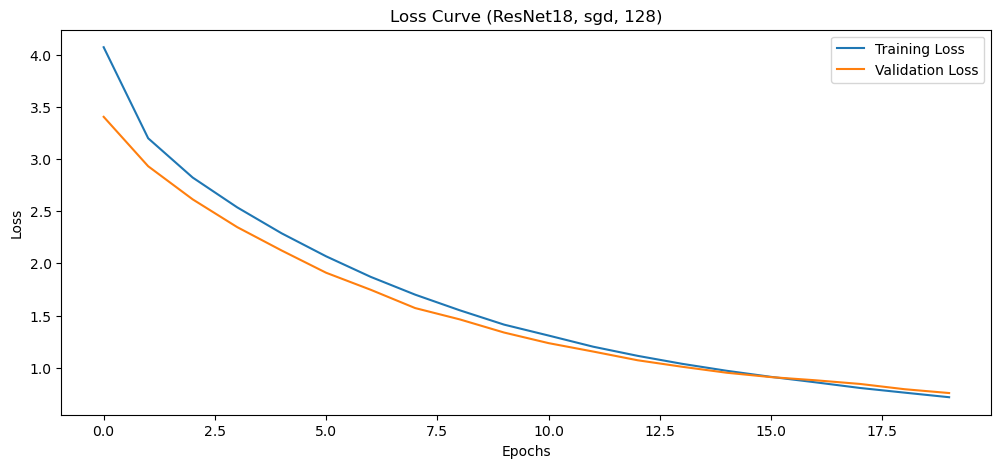

In [ ]:
# optimizer: sgd, image_size: 128
model = train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=20, patience=3,
                    model_name="ResNet18", optimizer_name="sgd",img_size=128)

#### Ablation Studies

Epoch 1/20 [Val]: 100%|██████████| 41/41 [00:06<00:00,  6.35it/s]


Epoch 1: Train Loss=4.1907, Val Loss: 3.6202, Train Acc=0.1719, Val Acc=0.2780
Saved best model at epoch 1


Epoch 2/20 [Val]: 100%|██████████| 41/41 [00:07<00:00,  5.79it/s]


Epoch 2: Train Loss=3.3933, Val Loss: 3.1916, Train Acc=0.2984, Val Acc=0.3318
Saved best model at epoch 2


Epoch 3/20 [Val]: 100%|██████████| 41/41 [00:06<00:00,  6.40it/s]


Epoch 3: Train Loss=3.0613, Val Loss: 2.9141, Train Acc=0.3652, Val Acc=0.3917
Saved best model at epoch 3


Epoch 4/20 [Val]: 100%|██████████| 41/41 [00:06<00:00,  6.40it/s]


Epoch 4: Train Loss=2.8086, Val Loss: 2.6930, Train Acc=0.4210, Val Acc=0.4516
Saved best model at epoch 4


Epoch 5/20 [Val]: 100%|██████████| 41/41 [00:06<00:00,  6.46it/s]


Epoch 5: Train Loss=2.5862, Val Loss: 2.5059, Train Acc=0.4632, Val Acc=0.4800
Saved best model at epoch 5


Epoch 6/20 [Val]: 100%|██████████| 41/41 [00:06<00:00,  6.40it/s]


Epoch 6: Train Loss=2.3869, Val Loss: 2.3406, Train Acc=0.5026, Val Acc=0.5100
Saved best model at epoch 6


Epoch 7/20 [Val]: 100%|██████████| 41/41 [00:06<00:00,  6.43it/s]


Epoch 7: Train Loss=2.2419, Val Loss: 2.2538, Train Acc=0.5366, Val Acc=0.5192
Saved best model at epoch 7


Epoch 8/20 [Val]: 100%|██████████| 41/41 [00:07<00:00,  5.48it/s]


Epoch 8: Train Loss=2.1065, Val Loss: 2.1217, Train Acc=0.5622, Val Acc=0.5469
Saved best model at epoch 8


Epoch 9/20 [Val]: 100%|██████████| 41/41 [00:06<00:00,  6.36it/s]


Epoch 9: Train Loss=1.9966, Val Loss: 2.0318, Train Acc=0.5809, Val Acc=0.5630
Saved best model at epoch 9


Epoch 10/20 [Val]: 100%|██████████| 41/41 [00:07<00:00,  5.79it/s]


Epoch 10: Train Loss=1.8747, Val Loss: 1.9401, Train Acc=0.6089, Val Acc=0.5822
Saved best model at epoch 10


Epoch 11/20 [Val]: 100%|██████████| 41/41 [00:06<00:00,  5.89it/s]


Epoch 11: Train Loss=1.7820, Val Loss: 1.8496, Train Acc=0.6214, Val Acc=0.5906
Saved best model at epoch 11


Epoch 12/20 [Val]: 100%|██████████| 41/41 [00:06<00:00,  6.28it/s]


Epoch 12: Train Loss=1.6958, Val Loss: 1.7773, Train Acc=0.6432, Val Acc=0.6091
Saved best model at epoch 12


Epoch 13/20 [Val]: 100%|██████████| 41/41 [00:06<00:00,  6.27it/s]


Epoch 13: Train Loss=1.5994, Val Loss: 1.7280, Train Acc=0.6565, Val Acc=0.6237
Saved best model at epoch 13


Epoch 14/20 [Val]: 100%|██████████| 41/41 [00:06<00:00,  6.33it/s]


Epoch 14: Train Loss=1.5254, Val Loss: 1.6607, Train Acc=0.6703, Val Acc=0.6290
Saved best model at epoch 14


Epoch 15/20 [Val]: 100%|██████████| 41/41 [00:06<00:00,  6.25it/s]


Epoch 15: Train Loss=1.4612, Val Loss: 1.6076, Train Acc=0.6843, Val Acc=0.6313
Saved best model at epoch 15


Epoch 16/20 [Val]: 100%|██████████| 41/41 [00:06<00:00,  6.22it/s]


Epoch 16: Train Loss=1.4029, Val Loss: 1.5848, Train Acc=0.6926, Val Acc=0.6444
Saved best model at epoch 16


Epoch 17/20 [Val]: 100%|██████████| 41/41 [00:06<00:00,  6.28it/s]


Epoch 17: Train Loss=1.3535, Val Loss: 1.5514, Train Acc=0.7048, Val Acc=0.6452
Saved best model at epoch 17


Epoch 18/20 [Val]: 100%|██████████| 41/41 [00:06<00:00,  5.97it/s]


Epoch 18: Train Loss=1.2899, Val Loss: 1.5094, Train Acc=0.7133, Val Acc=0.6490
Saved best model at epoch 18


Epoch 19/20 [Val]: 100%|██████████| 41/41 [00:06<00:00,  6.32it/s]


Epoch 19: Train Loss=1.2408, Val Loss: 1.4643, Train Acc=0.7278, Val Acc=0.6582
Saved best model at epoch 19


Epoch 20/20 [Val]: 100%|██████████| 41/41 [00:06<00:00,  6.24it/s]


Epoch 20: Train Loss=1.1895, Val Loss: 1.4572, Train Acc=0.7367, Val Acc=0.6559
ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum

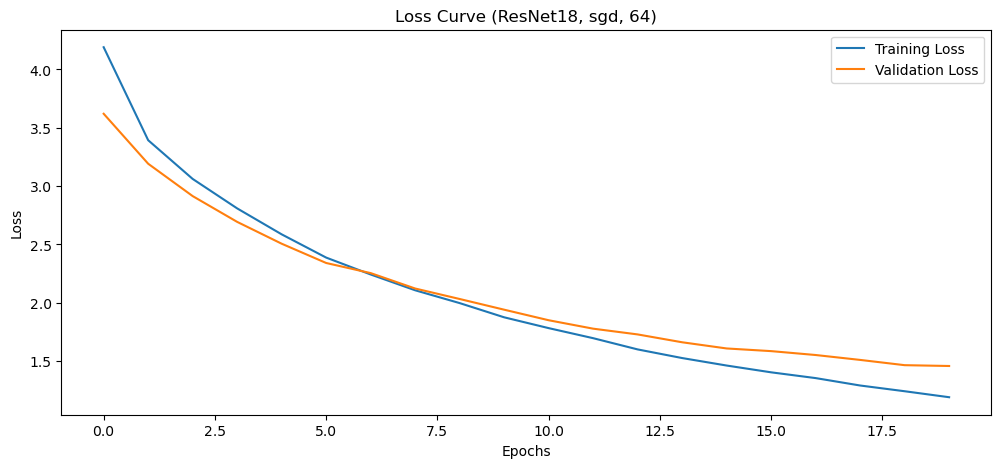

Testing: 100%|██████████| 41/41 [00:06<00:00,  6.26it/s]


Metrics appended to outputs/eval_results.json
Classification report saved to outputs/report_ResNet18_sgd_64.csv
Confusion matrix saved to outputs/confusion_matrix_ResNet18_sgd_64.png


In [ ]:
# optimizer: sgd, image_size: 64
model = train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=20, patience=5,
                    model_name="ResNet18", optimizer_name="sgd",img_size=64)
metrics = evaluate_model(model_path=f"{save_dir}/best_ResNet18_opt-sgd_img-64.pth", model=model, test_loader=test_loader, lb=lb)

Adam 通常收敛更快，最终 val_acc 更高。

Epoch 1/20 [Val]: 100%|██████████| 41/41 [00:12<00:00,  3.22it/s]


Epoch 1: Train Loss=1.8673, Val Loss: 0.7526, Train Acc=0.6330, Val Acc=0.8548
Saved best model at epoch 1


Epoch 2/20 [Val]: 100%|██████████| 41/41 [00:11<00:00,  3.67it/s]


Epoch 2: Train Loss=0.4876, Val Loss: 0.4490, Train Acc=0.9177, Val Acc=0.9094
Saved best model at epoch 2


Epoch 3/20 [Val]: 100%|██████████| 41/41 [00:10<00:00,  3.78it/s]


Epoch 3: Train Loss=0.2145, Val Loss: 0.3661, Train Acc=0.9704, Val Acc=0.9140
Saved best model at epoch 3


Epoch 4/20 [Val]: 100%|██████████| 41/41 [00:11<00:00,  3.60it/s]


Epoch 4: Train Loss=0.1060, Val Loss: 0.3247, Train Acc=0.9885, Val Acc=0.9155
Saved best model at epoch 4


Epoch 5/20 [Val]: 100%|██████████| 41/41 [00:10<00:00,  3.78it/s]


Epoch 5: Train Loss=0.0642, Val Loss: 0.3180, Train Acc=0.9941, Val Acc=0.9255
Saved best model at epoch 5


Epoch 6/20 [Val]: 100%|██████████| 41/41 [00:11<00:00,  3.64it/s]


Epoch 6: Train Loss=0.0366, Val Loss: 0.3019, Train Acc=0.9982, Val Acc=0.9224


Epoch 7/20 [Val]: 100%|██████████| 41/41 [00:11<00:00,  3.49it/s]


Epoch 7: Train Loss=0.0249, Val Loss: 0.2980, Train Acc=0.9988, Val Acc=0.9217


Epoch 8/20 [Val]: 100%|██████████| 41/41 [00:10<00:00,  3.77it/s]


Epoch 8: Train Loss=0.0190, Val Loss: 0.2841, Train Acc=0.9993, Val Acc=0.9255


Epoch 9/20 [Val]: 100%|██████████| 41/41 [00:11<00:00,  3.71it/s]


Epoch 9: Train Loss=0.0138, Val Loss: 0.2823, Train Acc=0.9993, Val Acc=0.9263
Saved best model at epoch 9


Epoch 10/20 [Val]: 100%|██████████| 41/41 [00:11<00:00,  3.72it/s]


Epoch 10: Train Loss=0.0108, Val Loss: 0.2740, Train Acc=0.9992, Val Acc=0.9324
Saved best model at epoch 10


Epoch 11/20 [Val]: 100%|██████████| 41/41 [00:11<00:00,  3.45it/s]


Epoch 11: Train Loss=0.0100, Val Loss: 0.2582, Train Acc=0.9995, Val Acc=0.9301


Epoch 12/20 [Val]: 100%|██████████| 41/41 [00:10<00:00,  3.80it/s]


Epoch 12: Train Loss=0.0069, Val Loss: 0.2680, Train Acc=0.9998, Val Acc=0.9278


Epoch 13/20 [Val]: 100%|██████████| 41/41 [00:10<00:00,  3.74it/s]


Epoch 13: Train Loss=0.0064, Val Loss: 0.2652, Train Acc=0.9993, Val Acc=0.9324


Epoch 14/20 [Val]: 100%|██████████| 41/41 [00:11<00:00,  3.68it/s]


Epoch 14: Train Loss=0.0053, Val Loss: 0.2565, Train Acc=0.9998, Val Acc=0.9309


Epoch 15/20 [Val]: 100%|██████████| 41/41 [00:10<00:00,  3.74it/s]


Epoch 15: Train Loss=0.0046, Val Loss: 0.2598, Train Acc=0.9997, Val Acc=0.9301


Epoch 16/20 [Val]: 100%|██████████| 41/41 [00:11<00:00,  3.70it/s]


Epoch 16: Train Loss=0.0042, Val Loss: 0.2616, Train Acc=0.9998, Val Acc=0.9301


Epoch 17/20 [Val]: 100%|██████████| 41/41 [00:11<00:00,  3.72it/s]


Epoch 17: Train Loss=0.0036, Val Loss: 0.2638, Train Acc=0.9998, Val Acc=0.9286


Epoch 18/20 [Val]: 100%|██████████| 41/41 [00:10<00:00,  3.75it/s]


Epoch 18: Train Loss=0.0037, Val Loss: 0.2709, Train Acc=0.9997, Val Acc=0.9278


Epoch 19/20 [Val]: 100%|██████████| 41/41 [00:11<00:00,  3.72it/s]


Epoch 19: Train Loss=0.0030, Val Loss: 0.2605, Train Acc=0.9998, Val Acc=0.9301
Early stopping triggered at epoch 19. Best val_acc = 0.9324
ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), 

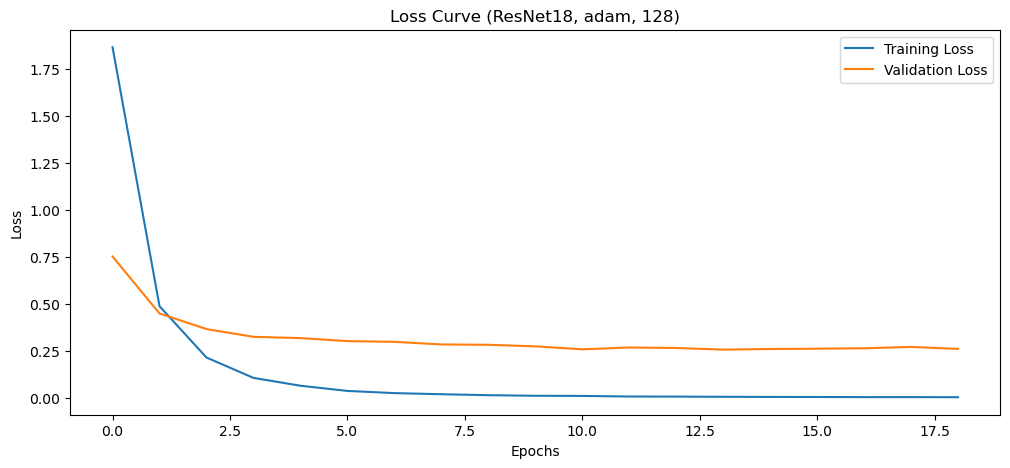

Testing: 100%|██████████| 41/41 [00:10<00:00,  3.76it/s]


Metrics appended to outputs/eval_results.json
Classification report saved to outputs/report_ResNet18_adam_128.csv
Confusion matrix saved to outputs/confusion_matrix_ResNet18_adam_128.png


In [ ]:
# optimizer: adam, image_size: 128
model = train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=20, patience=5,
                    model_name="ResNet18", optimizer_name="adam",img_size=128)
metrics = evaluate_model(model_path=f"{save_dir}/best_ResNet18_opt-adam_img-128.pth", model=model, test_loader=test_loader, lb=lb)

Epoch 1/20 [Val]: 100%|██████████| 41/41 [00:07<00:00,  5.18it/s]


Epoch 1: Train Loss=2.5485, Val Loss: 1.5892, Train Acc=0.4701, Val Acc=0.6551
Saved best model at epoch 1


Epoch 2/20 [Val]: 100%|██████████| 41/41 [00:07<00:00,  5.48it/s]


Epoch 2: Train Loss=1.1701, Val Loss: 1.1720, Train Acc=0.7392, Val Acc=0.7273
Saved best model at epoch 2


Epoch 3/20 [Val]: 100%|██████████| 41/41 [00:07<00:00,  5.62it/s]


Epoch 3: Train Loss=0.7030, Val Loss: 1.0061, Train Acc=0.8493, Val Acc=0.7604
Saved best model at epoch 3


Epoch 4/20 [Val]: 100%|██████████| 41/41 [00:07<00:00,  5.35it/s]


Epoch 4: Train Loss=0.4324, Val Loss: 0.9529, Train Acc=0.9160, Val Acc=0.7742
Saved best model at epoch 4


Epoch 5/20 [Val]: 100%|██████████| 41/41 [00:07<00:00,  5.37it/s]


Epoch 5: Train Loss=0.2648, Val Loss: 0.9052, Train Acc=0.9555, Val Acc=0.7842
Saved best model at epoch 5


Epoch 6/20 [Val]: 100%|██████████| 41/41 [00:07<00:00,  5.13it/s]


Epoch 6: Train Loss=0.1723, Val Loss: 0.8759, Train Acc=0.9730, Val Acc=0.7873
Saved best model at epoch 6


Epoch 7/20 [Val]: 100%|██████████| 41/41 [00:07<00:00,  5.38it/s]


Epoch 7: Train Loss=0.1120, Val Loss: 0.8650, Train Acc=0.9857, Val Acc=0.8034
Saved best model at epoch 7


Epoch 8/20 [Val]: 100%|██████████| 41/41 [00:07<00:00,  5.33it/s]


Epoch 8: Train Loss=0.0756, Val Loss: 0.8555, Train Acc=0.9916, Val Acc=0.7873


Epoch 9/20 [Val]: 100%|██████████| 41/41 [00:07<00:00,  5.21it/s]


Epoch 9: Train Loss=0.0551, Val Loss: 0.8488, Train Acc=0.9951, Val Acc=0.7957


Epoch 10/20 [Val]: 100%|██████████| 41/41 [00:07<00:00,  5.20it/s]


Epoch 10: Train Loss=0.0456, Val Loss: 0.8568, Train Acc=0.9951, Val Acc=0.7926


Epoch 11/20 [Val]: 100%|██████████| 41/41 [00:07<00:00,  5.14it/s]


Epoch 11: Train Loss=0.0359, Val Loss: 0.8414, Train Acc=0.9969, Val Acc=0.7972


Epoch 12/20 [Val]: 100%|██████████| 41/41 [00:08<00:00,  4.72it/s]


Epoch 12: Train Loss=0.0266, Val Loss: 0.8489, Train Acc=0.9980, Val Acc=0.7957


Epoch 13/20 [Val]: 100%|██████████| 41/41 [00:07<00:00,  5.25it/s]


Epoch 13: Train Loss=0.0241, Val Loss: 0.8536, Train Acc=0.9979, Val Acc=0.7980


Epoch 14/20 [Val]: 100%|██████████| 41/41 [00:07<00:00,  5.23it/s]


Epoch 14: Train Loss=0.0209, Val Loss: 0.8436, Train Acc=0.9982, Val Acc=0.7942


Epoch 15/20 [Val]: 100%|██████████| 41/41 [00:07<00:00,  5.25it/s]


Epoch 15: Train Loss=0.0174, Val Loss: 0.8414, Train Acc=0.9987, Val Acc=0.7919


Epoch 16/20 [Val]: 100%|██████████| 41/41 [00:07<00:00,  5.24it/s]


Epoch 16: Train Loss=0.0162, Val Loss: 0.8800, Train Acc=0.9979, Val Acc=0.7865
Early stopping triggered at epoch 16. Best val_acc = 0.8034
ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), 

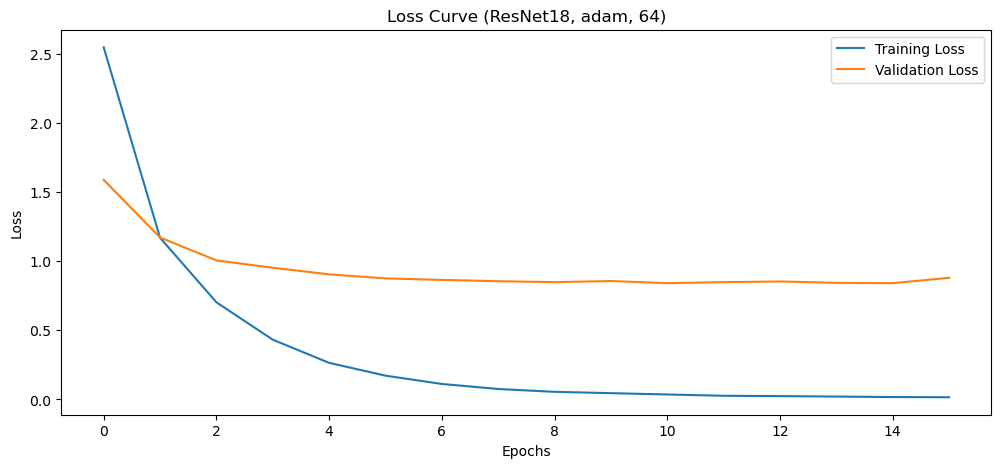

Testing: 100%|██████████| 41/41 [15:10<00:00, 22.20s/it]   


Metrics appended to outputs/eval_results.json
Classification report saved to outputs/report_ResNet18_adam_64.csv
Confusion matrix saved to outputs/confusion_matrix_ResNet18_adam_64.png


In [ ]:
# optimizer: adam, image_size: 64
model = train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=20, patience=5,
                    model_name="ResNet18", optimizer_name="adam",img_size=64)
metrics = evaluate_model(model_path=f"{save_dir}/best_ResNet18_opt-adam_img-64.pth", model=model, test_loader=test_loader, lb=lb)